In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *

100%|██████████| 10000/10000 [00:44<00:00, 226.56it/s]


The Hypothesis H0 was rejected
c_alpha_star is 4.0616


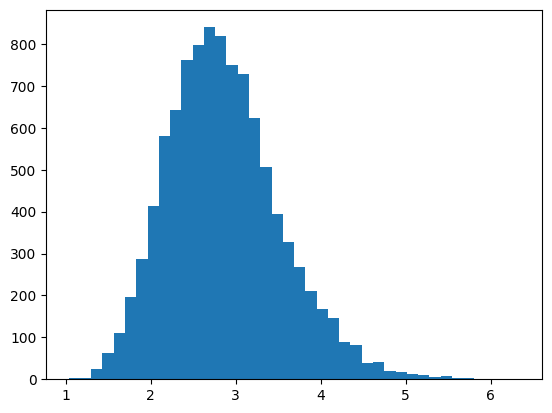

In [24]:
N = 500
x = np.arange(N)/N
m1 = np.sin(np.pi*2*x)
m2 = np.sin(np.pi*2*x) + np.exp((-800)*np.power(x-0.5, 2))
sigma = 0.7 - 1.4*np.square(x-0.5)

y1, y2 = generate_synthetic_data(m1, m2, sigma)
rejected_bool, c_alpha_star, Tn_star = wild_bootstrap(y1, y2, bartlett_priestley_kernel, h=0.02, g=0.03, residual_function=get_wild_residual, B=1000, alpha=0.05)

plt.hist(Tn_star, bins=40, density=True)
plt.show()

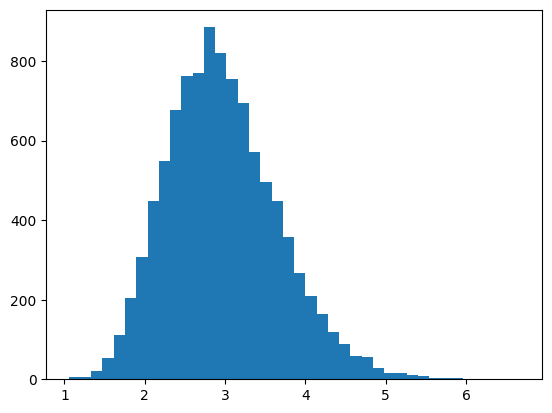

In [27]:
def montecarlo_Tn(kernel_function, h, M):
    """Generate Monte Carlo estimate of "true" density of Tn"""
    def _generate_Tn():
        # auxiliary function for each iteration
        y1, y2 = generate_synthetic_data(m1, m1, sigma)
        _m1 = smoothed_estimate(y1, kernel_function, h)
        _m2 = smoothed_estimate(y2, kernel_function, h)
        return calculate_Tn(_m1, _m2, h)
    
    N = 500
    x = np.arange(N)/N
    m1 = np.sin(np.pi*2*x)
    m2 = np.sin(np.pi*2*x) + np.exp((-800)*np.power(x-0.5, 2))
    sigma = 0.7 - 1.4*np.square(x-0.5)
    return [_generate_Tn() for _ in range(M)]

# run & plot
Tn_monte = montecarlo_Tn(bartlett_priestley_kernel, h=0.02, M=1000)
plt.hist(Tn_monte, bins=40)
plt.show()

# Examination

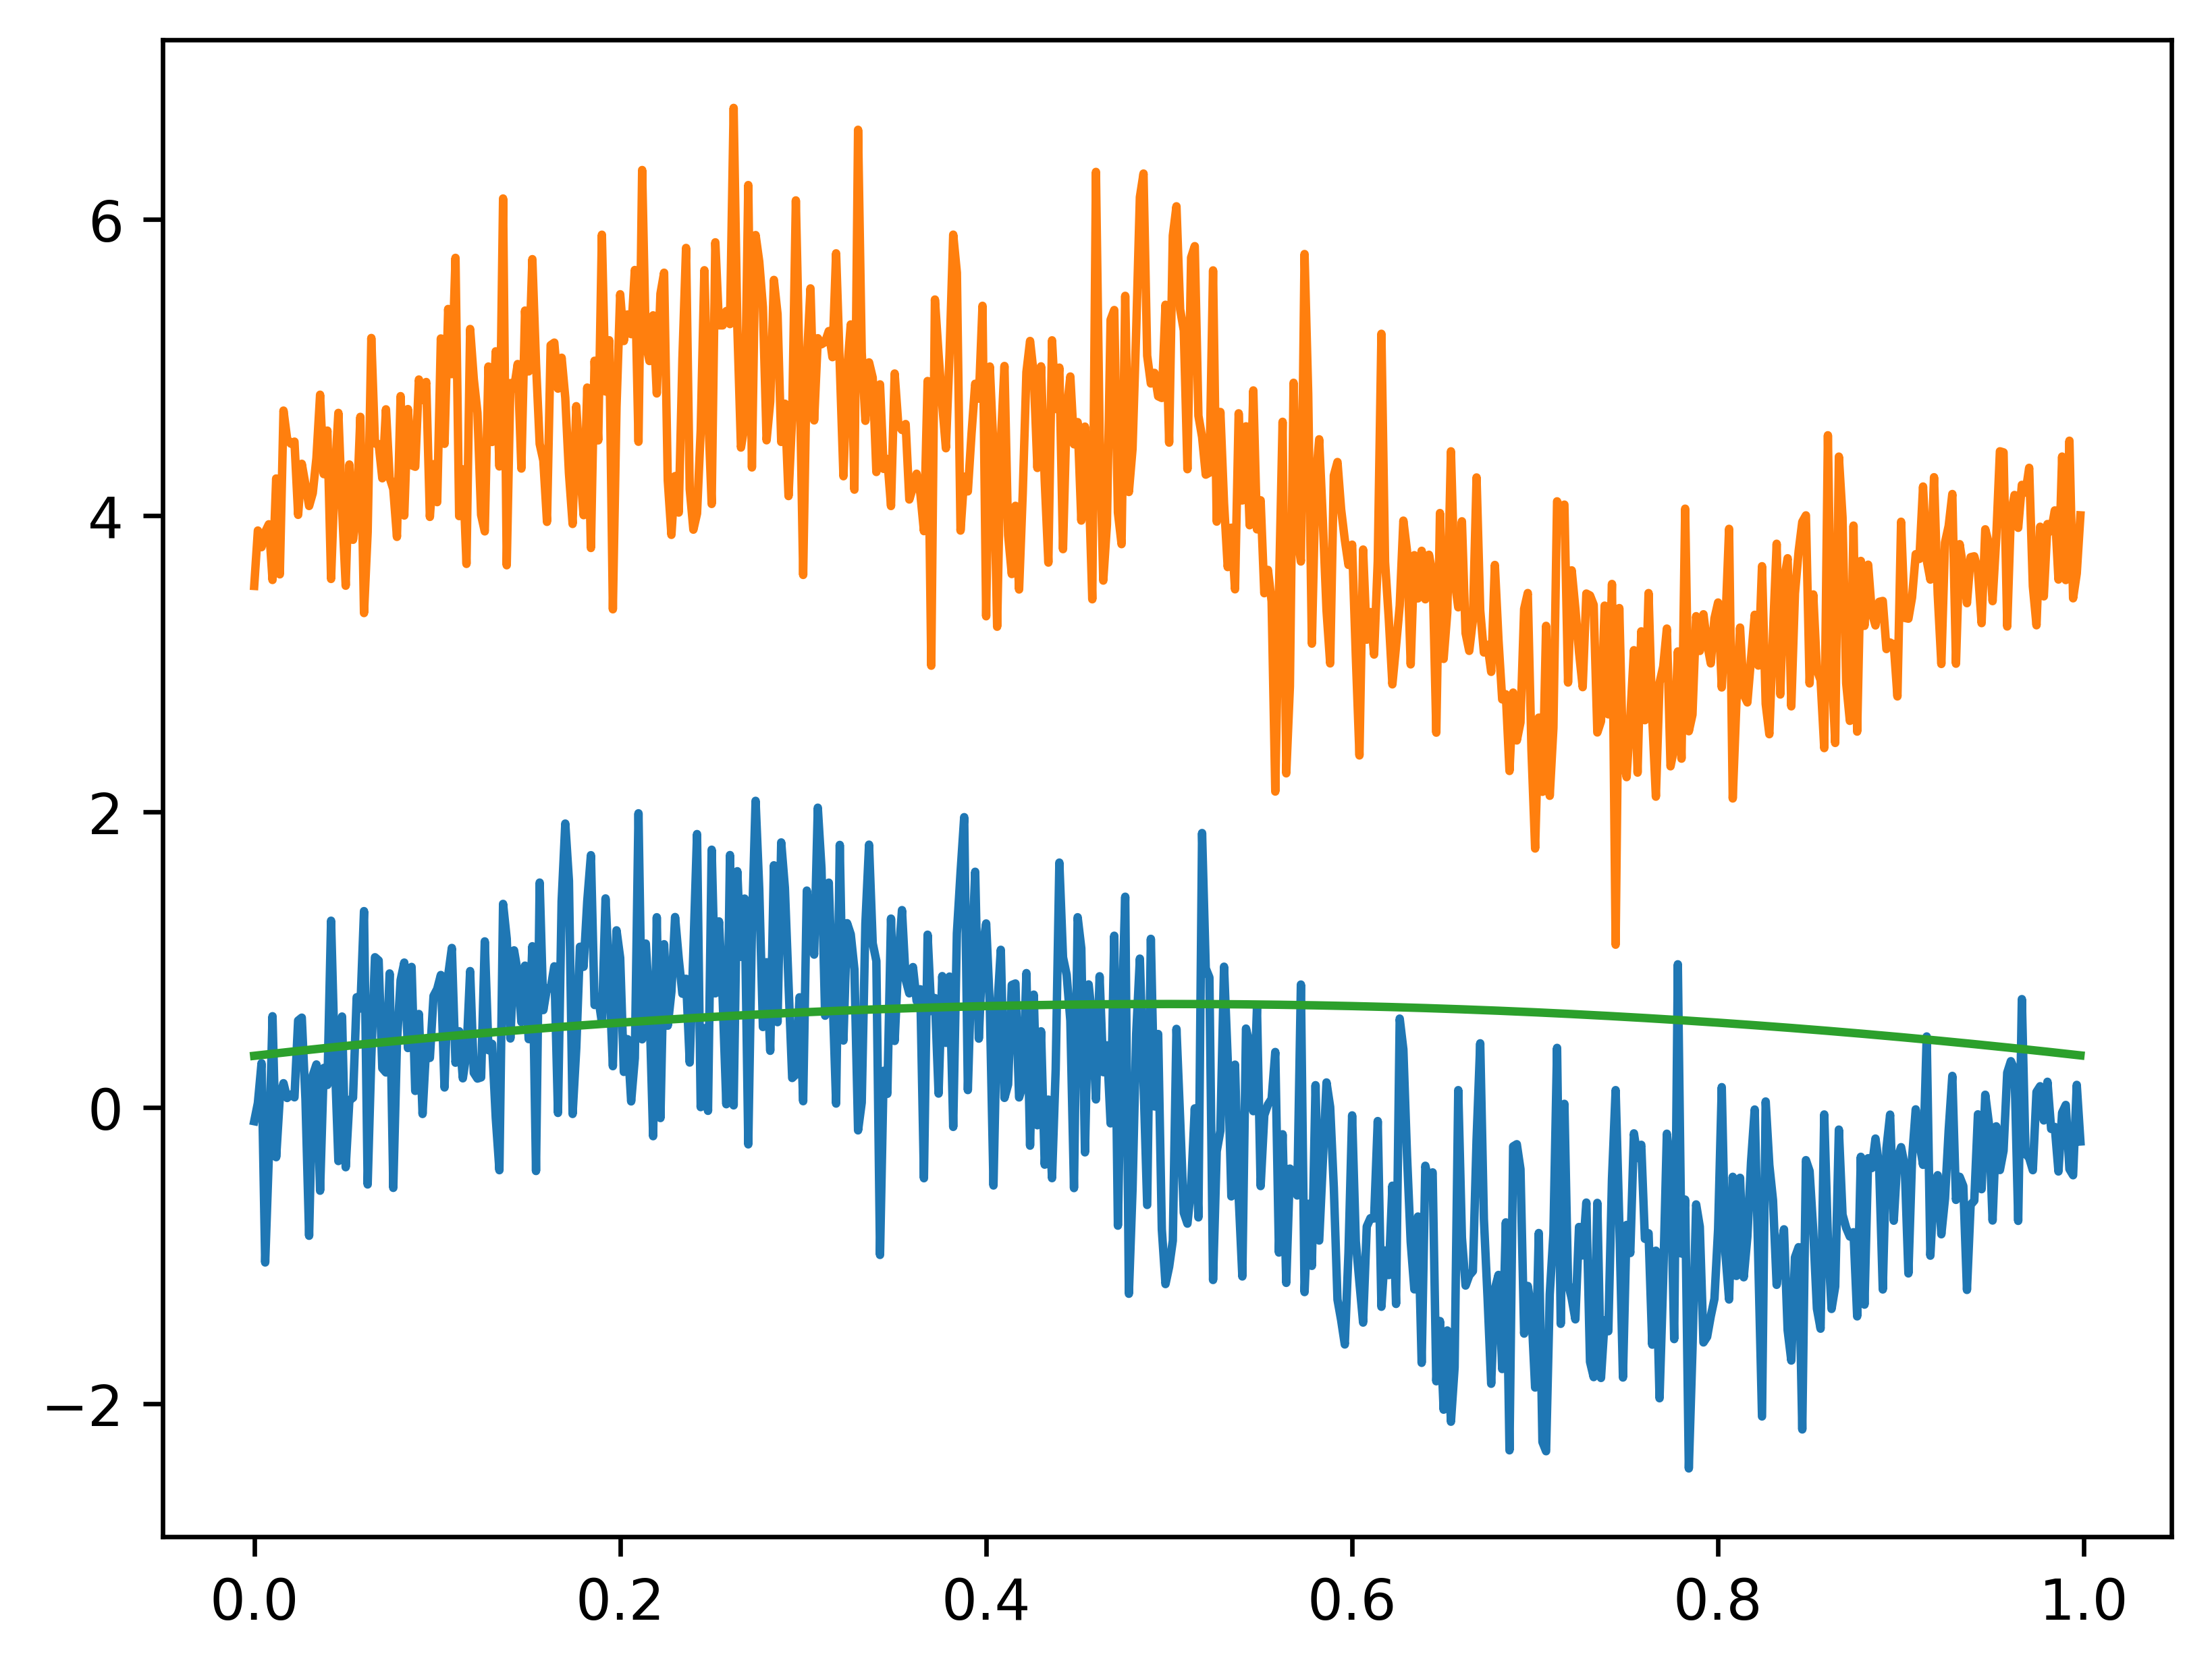

In [12]:
# plotting generated signals
N = 500
x = np.arange(N)/N
m1 = np.sin(np.pi*2*x)
m2 = np.sin(np.pi*2*x) + np.exp((-800)*np.power(x-0.5, 2))
sigma = 0.7 - 1.4*np.square(x-0.5)
y1, y2 = generate_synthetic_data(m1, m2, sigma)
plt.figure(dpi=600)
plt.plot(x, y1)
plt.plot(x, y2+4)
plt.plot(x, sigma)
plt.show()

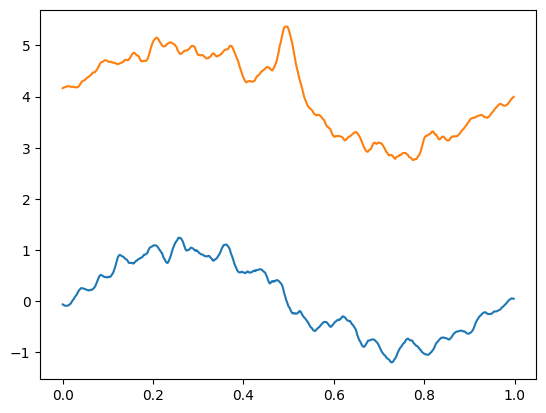

In [11]:
# plotting smoothed estimates
m1 = smoothed_estimate(y1, bartlett_priestley_kernel, h=0.02)
m2 = smoothed_estimate(y2, bartlett_priestley_kernel, h=0.02)
plt.plot(x, m1)
plt.plot(x, m2+4)
# plt.plot(x,np.square(m1-m2))
# np.sum(np.square(m1-m2))*np.sqrt(0.02)
plt.show()

# Old Snippets

In [53]:
epsilon_hat = np.random.random_sample(10)
x_all = np.zeros((1000000, 10))
for i in range(1000000):
    x_all[i, :] = get_wild_residual_normal(epsilon_hat)
print(np.square(epsilon_hat))
print(np.power(epsilon_hat, 3))
print(np.mean(x_all, axis=0))
print(np.mean(np.square(x_all), axis=0))
print(np.mean(np.power(x_all, 3), axis=0))

[0.13577302 0.61535688 0.05483888 0.00195931 0.98696543 0.59731777
 0.30678458 0.43892964 0.12777103 0.00440108]
[5.00288125e-02 4.82714778e-01 1.28420060e-02 8.67273686e-05
 9.80511992e-01 4.61645014e-01 1.69922268e-01 2.90798633e-01
 4.56718471e-02 2.91970797e-04]
[ 8.46502879e-05 -1.99748769e-04  4.07817114e-04  8.72737879e-05
  1.10512251e-03  7.09511258e-04 -2.84110485e-04 -3.37913755e-04
 -3.63928846e-04 -5.34928480e-05]
[0.1362052  0.61386156 0.05504776 0.00196538 0.98445131 0.59749675
 0.30567715 0.43817948 0.12760129 0.0043904 ]
[1.25257266e-01 1.20002370e+00 3.21806678e-02 2.17707046e-04
 2.41981002e+00 1.15145347e+00 4.20882342e-01 7.22787293e-01
 1.14017265e-01 7.25003785e-04]


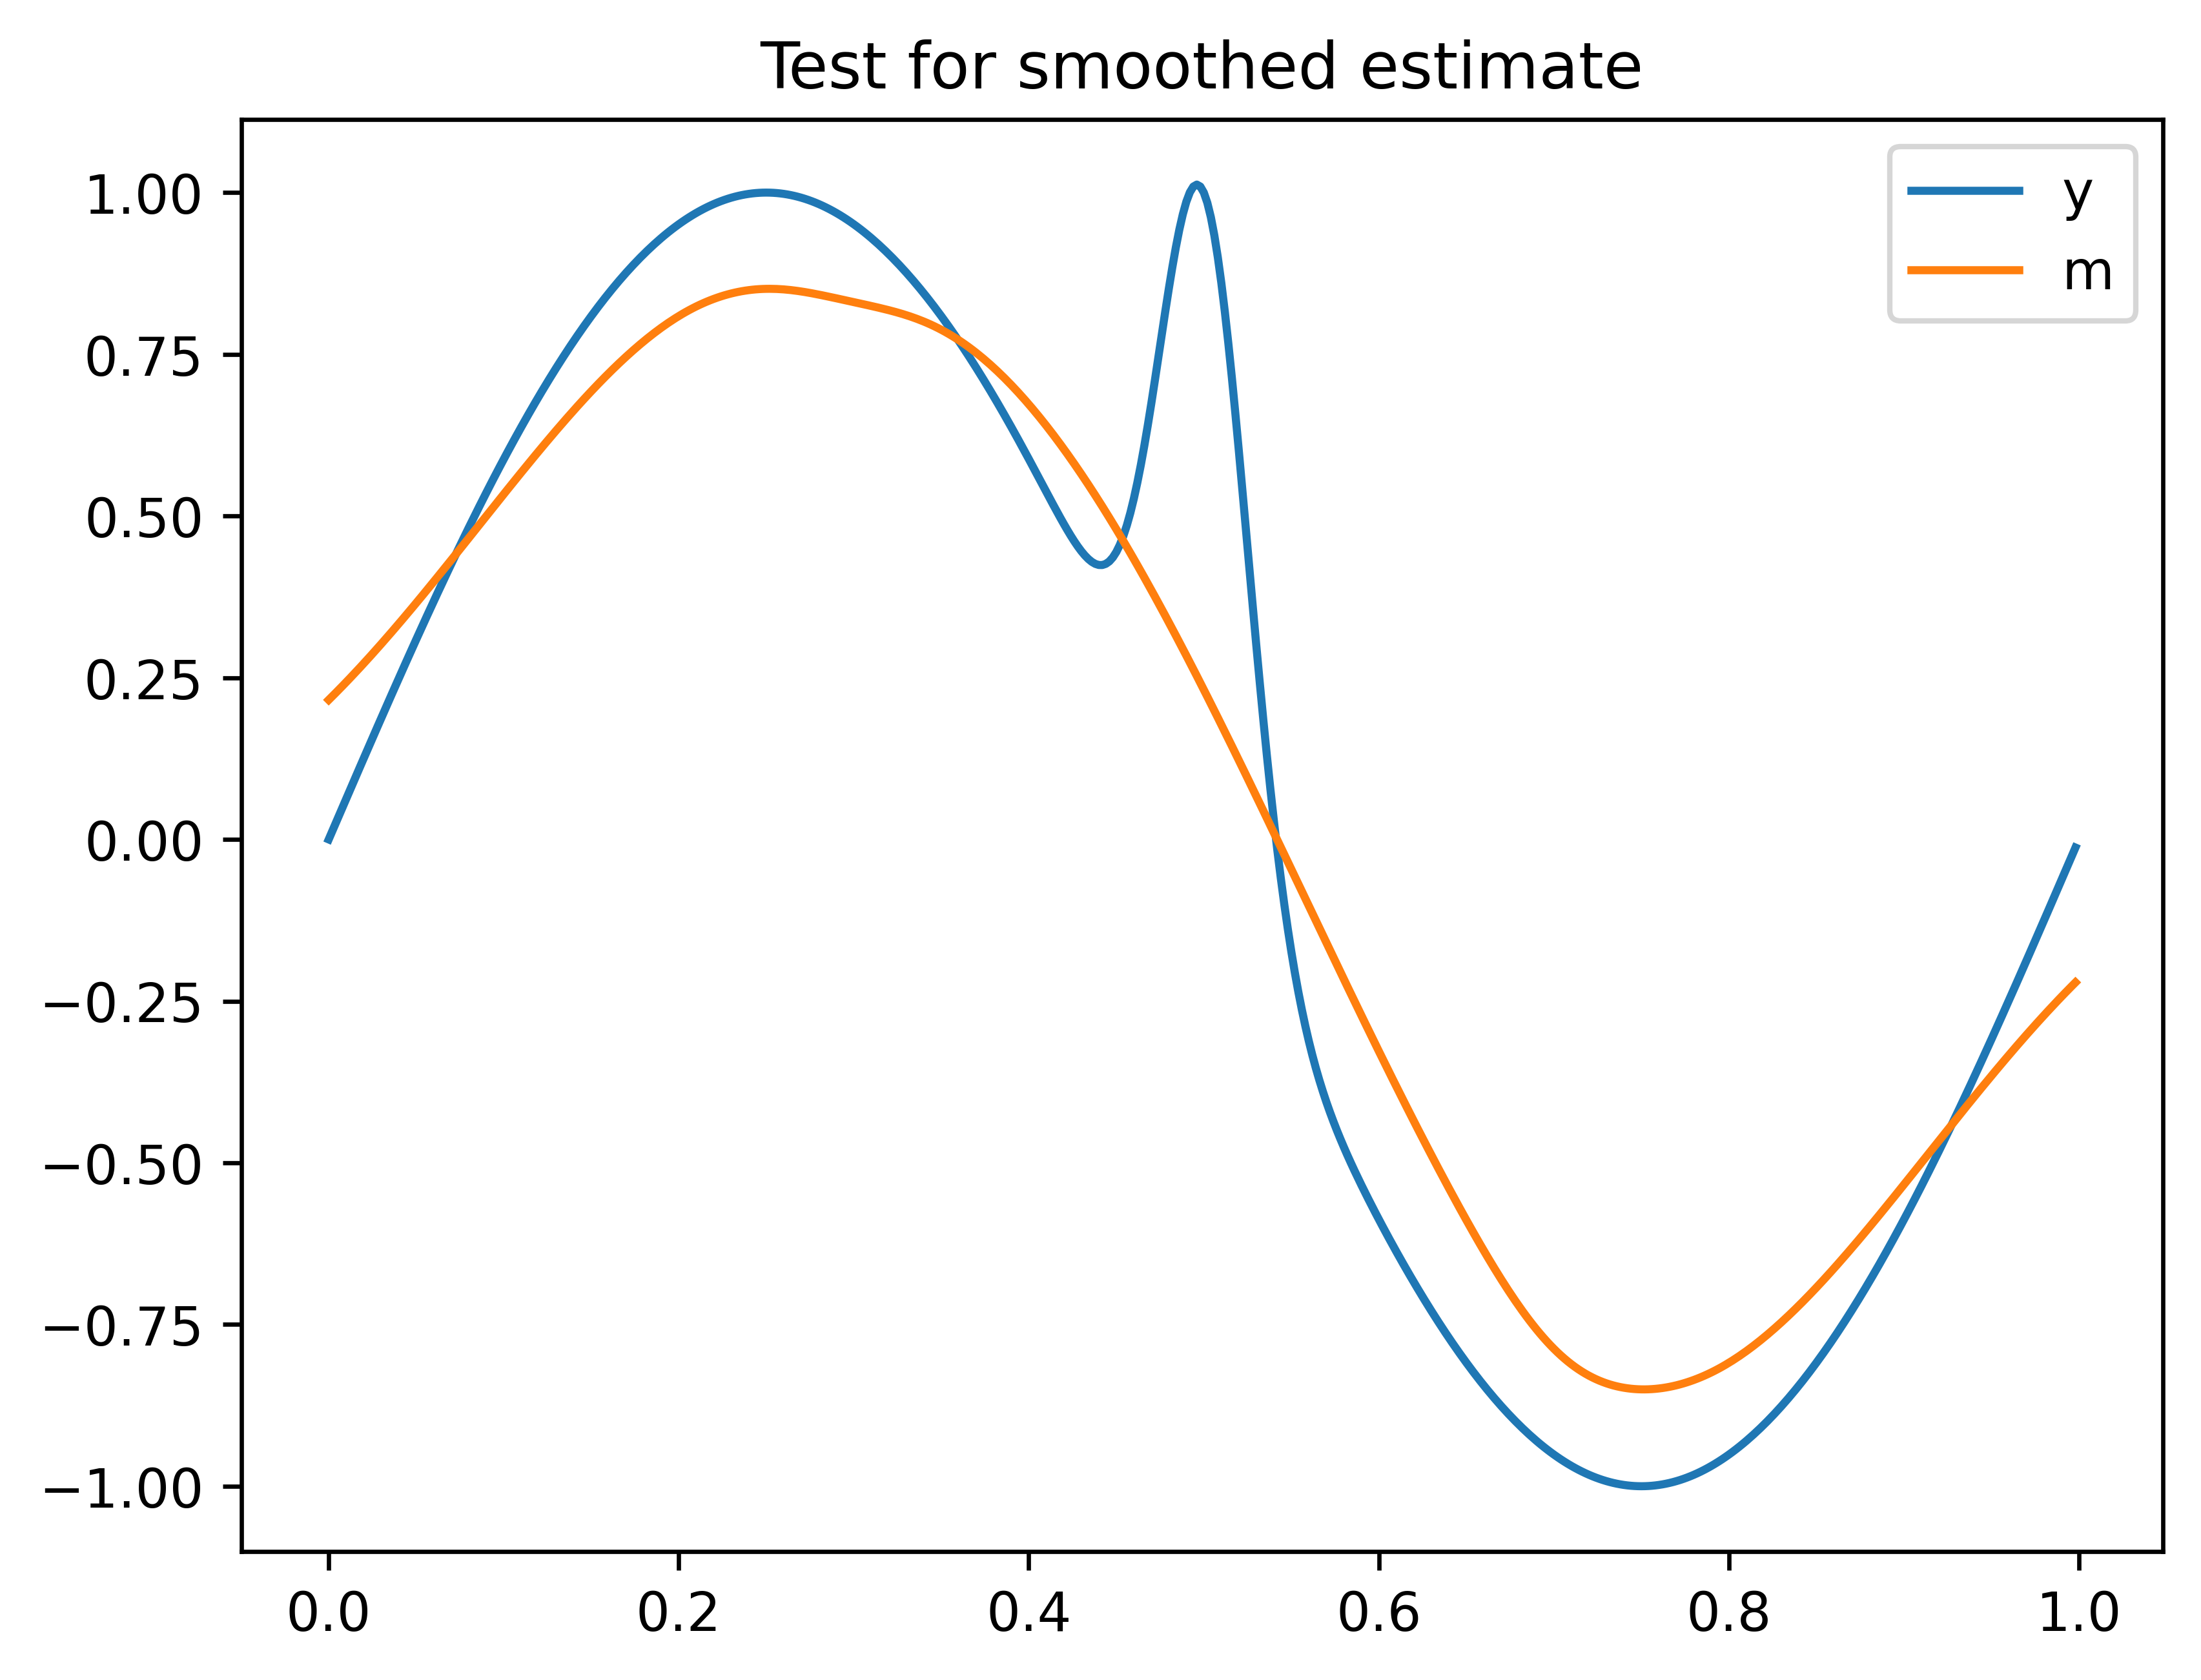

In [34]:
import matplotlib.pyplot as plt 
N = 500
x = np.arange(N)/N
y = np.sin(np.pi * 2* x) + np.exp((-800)*np.power(x-0.5, 2))
m = smoothed_estimate(y, bartlett_priestley_kernel, h=0.2)

plt.figure(dpi=600)
plt.plot(x, y)
plt.plot(x, m)
plt.title("Test for smoothed estimate")
plt.legend(["y", "m"])
plt.show()